1.13.1
Number of training examples: 60000
Number of test examples:     10000


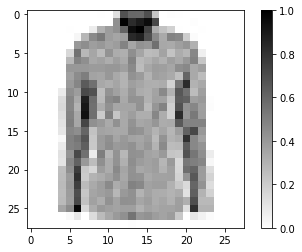

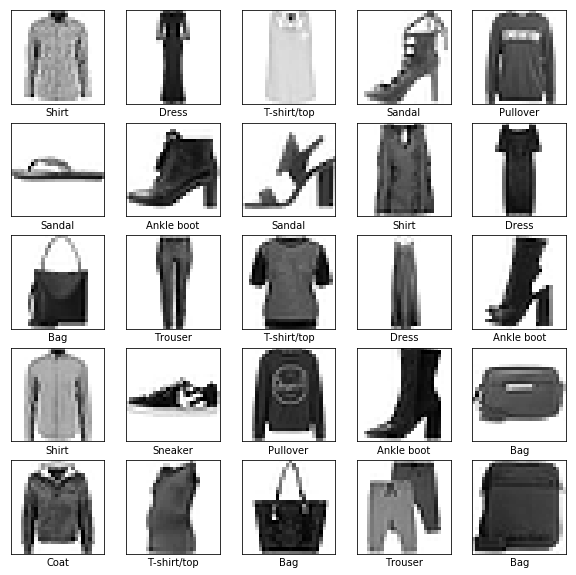

Epoch 1/10
1875/1875 [==============================] - 135s 72ms/step - loss: 0.3945 - acc: 0.8596
Epoch 2/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.2572 - acc: 0.9060
Epoch 3/10
1875/1875 [==============================] - 87s 46ms/step - loss: 0.2128 - acc: 0.9219
Epoch 4/10
1875/1875 [==============================] - 96s 51ms/step - loss: 0.1826 - acc: 0.9327
Epoch 5/10
1875/1875 [==============================] - 107s 57ms/step - loss: 0.1565 - acc: 0.94180s - loss: 0.15
Epoch 6/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1321 - acc: 0.9522
Epoch 7/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1110 - acc: 0.9590
Epoch 8/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0905 - acc: 0.9668
Epoch 9/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0804 - acc: 0.9701
Epoch 10/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0651 - acc

In [6]:
%matplotlib inline

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print(tf.__version__)

# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()  

# Load fashion MNIST dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# the class names are not included with the dataset, store them here to use later when plotting the images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# Let's explore the format of the dataset before training the model. 
# The following shows there are 60,000 images in the training set, and 10000 images in the test set
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

# The value of each pixel in the image data is an integer in the range [0,255].
# For the model to work properly, these values need to be normalized to the range [0,1].
# So here we create a normalization function, and then apply it to each image in the test and train datasets.
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

# Display the first 25 images from the training set and display the class name below each image. 
# Verify that the data is in the correct format and we're ready to build and train the network.
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# "convolutions": tf.keras.layers.Conv2D and MaxPooling2D— Network start with two pairs of Conv/MaxPool.
# The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image 
# size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted 
# images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) 
# with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 
# outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described 
# what a Convolution does, but we haven't yet covered how you chain multiples of these together. 
# We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand 
# the kind of operation a convolutional filter performs
# output: tf.keras.layers.Dense — A 128-neuron, followed by 10-node softmax layer. Each node represents a class
# of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it,
# and outputs a value in the range [0, 1], representing the probability that the image belongs to that class. 
# The sum of all 10 node values is 1.
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
# Loss function — An algorithm for measuring how far the model's outputs are from the desired output. 
#   The goal of training is this measures loss.
# Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
# Metrics —Used to monitor the training and testing steps. 
#   The following example uses *accuracy*, the fraction of the images that are correctly classified.
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# First, we define the iteration behavior for the train dataset:
# Repeat forever by specifying dataset.repeat() (the epochs parameter described below 
# limits how long we perform training).
# The dataset.shuffle(60000) randomizes the order so our model cannot learn anything 
# from the order of the examples.
# And dataset.batch(32) tells model.fit to use batches of 32 images and labels when 
# updating the model variables.
# Training is performed by calling the model.fit method:
# Feed the training data to the model using train_dataset.
# The model learns to associate images and labels.
# The epochs=5 parameter limits training to 5 full iterations of the training dataset, 
# so a total of 5 * 60000 = 300000 examples.
# (Don't worry about steps_per_epoch, the requirement to have this flag will soon be removed.)
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))



313/313 [==============================] - 6s 21ms/step - loss: 0.3256 - acc: 0.9177
Accuracy on test dataset: 0.9177
(28, 28, 1)
(1, 28, 28, 1)
[[1.7576681e-07 3.1357538e-12 2.0504600e-04 1.6464393e-08 3.6914919e-02
  2.8044880e-12 9.6287996e-01 4.2855483e-10 9.3577084e-11 3.5304193e-09]]


6

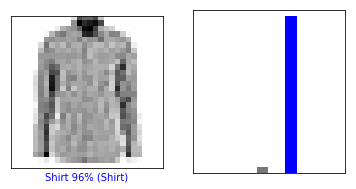

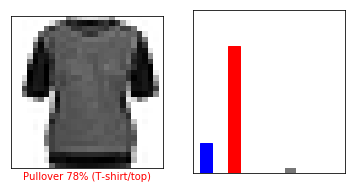

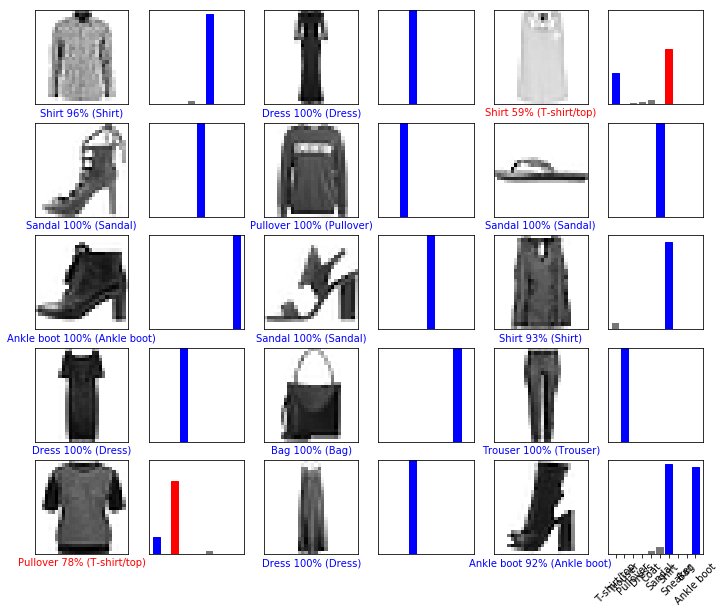

In [7]:
# compare how the model performs on the test dataset. Use all examples we have in the test dataset 
# to assess accuracy.
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

# With the model trained, we can use it to make predictions about some images.
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape

predictions[0]

np.argmax(predictions[0])

class_names[np.argmax(predictions[0])]

def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
    
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

    
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

predictions_single = model.predict(img)

print(predictions_single)

plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

np.argmax(predictions_single[0])

